<a href="https://www.kaggle.com/code/andrey36912/notebookac402befd2?scriptVersionId=192789734" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [13]:
import numpy as np
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [15]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'


dataset = datasets.ImageFolder(root=data_dir)

In [16]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'
dataset1 = datasets.ImageFolder(root=data_dir)

In [17]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'
dataset2 = datasets.ImageFolder(root=data_dir)

In [18]:
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset, dataset1, dataset2])
len(dataset)

10661

In [19]:
classes = dataset.datasets[0].classes  
num_classes = len(classes)
print(classes)
print(f'Number of classes: {num_classes}')


['all', 'hem']
Number of classes: 2


In [20]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [21]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

In [22]:
train_data.dataset.transform = train_transform
val_data.dataset.transform = test_transform
print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(val_data)}')

Number of training samples: 8528
Number of validation samples: 2133


In [23]:
len(train_data), len(val_data)

(8528, 2133)

In [24]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [25]:
class ImageDataset(torch.utils.data.Dataset):
   
    def __init__(self, root_dir, transform=None):
       
        self.root_dir = root_dir
        self.image_paths, self.labels = self.get_paths_and_labels()
        self.transform = transform

    def get_paths_and_labels(self):
        image_paths = []
        labels = []
        for label in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    image_paths.append(img_path)
                    labels.append(label)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label_name = self.labels[idx]
        label = 0 if label_name == 'all' else 1  
        if self.transform:
            image = self.transform(image)
        return image, label

In [26]:
os.listdir(data_dir)

['all', 'hem']

In [27]:
custom_train_data = ImageDataset(data_dir, transform=train_transform)


In [28]:

batch_size = 32
train_loader = DataLoader(custom_train_data, shuffle=True, batch_size=batch_size)

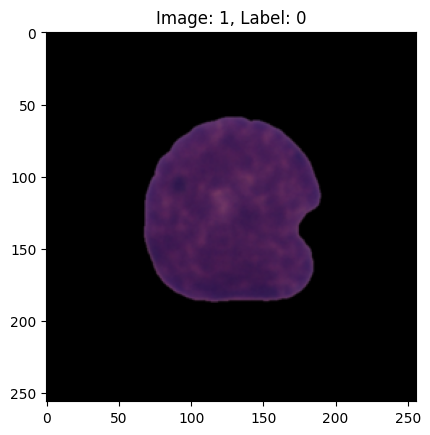

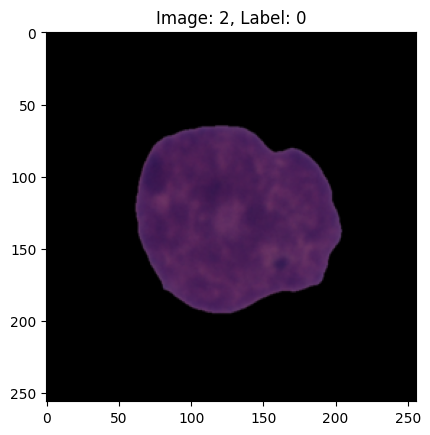

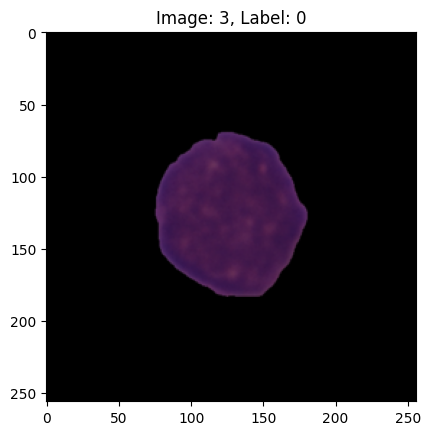

In [29]:
import matplotlib.pyplot as plt

for i in range(3):  
    img, label = custom_train_data[i]

    img = img.numpy().transpose((1, 2, 0))  

    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label}")
    plt.show()

In [30]:
class FractureClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(32*6*6, 256)
        self.linear2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool3(out)
        out = self.conv5(out)
        out = F.relu(out)
        out = self.pool4(out)
        out = self.conv6(out)
        out = F.relu(out)
        out = self.pool5(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)
        with torch.no_grad():
            y_pred = self.forward(X)
        return y_pred.cpu().numpy()

    

In [31]:
model = FractureClassifier(num_classes).to(device)
print(model)

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=2, bias=True)
)


In [32]:
!pip install -q torchsummary

In [33]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 252, 252]           1,168
         MaxPool2d-3         [-1, 16, 126, 126]               0
            Conv2d-4         [-1, 32, 124, 124]           4,640
         MaxPool2d-5           [-1, 32, 62, 62]               0
            Conv2d-6           [-1, 32, 60, 60]           9,248
         MaxPool2d-7           [-1, 32, 30, 30]               0
            Conv2d-8           [-1, 32, 28, 28]           9,248
         MaxPool2d-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 12, 12]           9,248
        MaxPool2d-11             [-1, 32, 6, 6]               0
          Flatten-12                 [-1, 1152]               0
           Linear-13                  [-1, 256]         295,168
           Linear-14                   

In [34]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
import time


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, metrics, device, task):
    history = {'train_loss': [], 'val_loss': [], 'train_metrics': [], 'val_metrics': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_true = []
        train_pred = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(outputs.argmax(dim=1).cpu().numpy())
        
        train_loss /= len(train_loader.dataset)
        train_metric = [metric(train_true, train_pred) for metric in metrics]
        
        model.eval()
        val_loss = 0.0
        val_true = []
        val_pred = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(outputs.argmax(dim=1).cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        val_metric = [metric(val_true, val_pred) for metric in metrics]
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metrics'].append(train_metric)
        history['val_metrics'].append(val_metric)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Metrics: {train_metric}, Val Metrics: {val_metric}')
    
    return history


In [36]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[f'train_{name}'], label='train')
    plt.plot(history[f'val_{name}'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    plt.show()
plot_metric(history, 'loss')   